<a href="https://colab.research.google.com/github/NurlanNKZ/heat-equation-experiments/blob/main/Num_exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Полный модуль: анализ сходимости аппроксимации с точной и шумной информацией
!pip install torch numpy matplotlib -q

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [16]:
# Full module: Convergence analysis of approximation using exact and noisy data

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem parameters
s = 2         # dimension
r = 4         # smoothness
theta = 1.1   # second index
L = 1.0       # domain size
n_max = 7     # maximum order of Fourier coefficients

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Spatial grid
grid_points = 64
x_vals = torch.linspace(0, L, grid_points, device=device)
X, Y = torch.meshgrid(x_vals, x_vals, indexing='ij')
Z = torch.stack((X, Y), dim=-1)

# Helper functions
def get_k(m):
    abs_m = torch.maximum(torch.abs(m), torch.tensor([1], device=device))
    return torch.ceil(torch.log2(abs_m.float())).max(dim=1).int()

def build_Qn(n):
    grid_range = torch.arange(-2**n, 2**n + 1, device=device)
    m1, m2 = torch.meshgrid(grid_range, grid_range, indexing='ij')
    M = torch.stack((m1, m2), dim=-1).reshape(-1, 2)
    return M[torch.any(torch.abs(M) > 1, dim=1)]

def compute_hat_f1(M):
    k_vals = get_k(M)
    coeffs = 2 ** (-k_vals * (r - s/2 + 1/theta))
    return coeffs.to(torch.complex64)

def compute_hat_f(M, r=r, s=s, theta=theta):
    norm_sq = (M.float()**2).sum(dim=1)
    coeffs = 1.0 / (1 + norm_sq)**(r/2 + 1/theta)
    return coeffs.to(torch.complex64)

def aggregate(M, coeffs, Z, t):
    phase = torch.einsum('ij,xyj->ixy', M.float(), Z)
    decay = torch.exp(-4 * np.pi**2 * (M.float()**2).sum(dim=1) * t)
    terms = coeffs * decay
    cos_phase = torch.cos(2 * np.pi * phase)
    sin_phase = torch.sin(2 * np.pi * phase)
    real = torch.sum(cos_phase * terms.real[:, None, None] - sin_phase * terms.imag[:, None, None], dim=0)
    imag = torch.sum(sin_phase * terms.real[:, None, None] + cos_phase * terms.imag[:, None, None], dim=0)
    return torch.complex(real, imag)

def solution(M, coeffs, Z, t):
    return aggregate(M, coeffs, Z, t)

def add_noise(c_exact, eps_n, mode="random", eta_n=None):
    """
    Returns perturbed coefficients c̃_m = c_m + noise
    mode: "random", "systematic", "eta_scaled"
    """
    if mode == "random":
        noise_real = torch.rand_like(c_exact.real) * eps_n
        noise_imag = torch.rand_like(c_exact.imag) * eps_n
        noise = torch.complex(noise_real, noise_imag)
        return c_exact + noise

    elif mode == "systematic":
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_n),
            torch.full_like(c_exact.imag, eps_n)
        )
        return c_exact + noise

    elif mode == "eta_scaled":
        if eta_n is None:
            raise ValueError("eta_n must be specified for eta_scaled noise")
        eps_eta = eps_n * eta_n
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_eta),
            torch.full_like(c_exact.imag, eps_eta)
        )
        return c_exact + noise

    else:
        raise ValueError(f"Unknown noise mode: {mode}")

def compute_L2_error(u_exact, u_approx):
    diff = u_exact - u_approx
    return torch.sqrt((diff * torch.conj(diff)).real.mean()).item()

def compute_max_error(u_exact, u_approx):
    diff = u_exact - u_approx
    return torch.max(diff.real).item()

# Slope estimation (for log-log plot)
def get_slope(x, y):
    return np.polyfit(x, y, deg=1)[0]


# Главный модуль анализа

def run_convergence_analysis(t_val=0.01, mode="random", eta_function=None, save_csv=False):
    if eta_function is None:
        eta_function = lambda n: 2**n + 1
    results = []

    for n in range(2, 7):
        M_all = build_Qn(n_max)  # fixed large frequency set
        f_hat_all = compute_hat_f(M_all)

        M_n = build_Qn(n)  # truncated set Q_n
        idx = torch.any((M_all[:, None, :] == M_n).all(dim=2), dim=1)
        c_n = f_hat_all[idx]

        eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
        eta_n = eta_function(n)

        u_ref = aggregate(M_all, f_hat_all, Z, t_val).cpu()

        phi_exact = aggregate(M_n, c_n, Z, t_val).cpu()
        phi_eps = aggregate(M_n, add_noise(c_n, eps_n, mode=mode), Z, t_val).cpu()
        phi_eta = aggregate(M_n, add_noise(c_n, eps_n, mode="eta_scaled", eta_n=eta_n), Z, t_val).cpu()

        err_exact = compute_L2_error(u_ref, phi_exact)
        err_eps = compute_L2_error(u_ref, phi_eps)
        err_eta = compute_L2_error(u_ref, phi_eta)

        err_exact_max = compute_max_error(u_ref, phi_exact)
        err_eps_max = compute_max_error(u_ref, phi_eps)
        err_eta_max = compute_max_error(u_ref, phi_eta)

        results.append({
            "n": n,
            "N": M_n.shape[0]+9,
            "eps_n": eps_n,
            "eta_n": eta_n,
            "L2_exact": err_exact,
            "L2_eps": err_eps,
            "L2_eta": err_eta,
        })

    df = pd.DataFrame(results)
    df['logN'] = np.log10(df['N'])
    df['log_err_exact'] = np.log10(df['L2_exact'])
    df['log_err_eps'] = np.log10(df['L2_eps'])
    df['log_err_eta'] = np.log10(df['L2_eta'])

    # Plot: L2 convergence
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'x--', label="Exact")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=r"Noise $\varepsilon_n$")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=r"Noise $\varepsilon_n \cdot \eta_n$")
    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Convergence in $L^2$ norm at t = {t_val}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Slope estimates
    slope_exact = get_slope(df['logN'], df['log_err_exact'])
    slope_eps = get_slope(df['logN'], df['log_err_eps'])
    slope_eta = get_slope(df['logN'], df['log_err_eta'])
    alpha_theor = -(r/s + 0.5)

    # Plot: log-log error slopes with theoretical line
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'o-', label=f"Exact, α = {slope_exact:.2f}")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=f"Noise εₙ, α = {slope_eps:.2f}")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=f"Noise εₙ·ηₙ, α = {slope_eta:.2f}")

    x_line = np.linspace(df['logN'].min(), df['logN'].max(), 100)
    y_line = alpha_theor * x_line + df['log_err_exact'].iloc[0]
    plt.plot(x_line, y_line, '--', color='gray', label=f"Theory: α = {alpha_theor:.2f}")
    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Convergence order at t = {t_val}, theoretical: α = {alpha_theor:.2f}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_csv:
        df.to_csv(f"errors_eta_slope_t{t_val}.csv", index=False)
        print(f"Table saved to errors_eta_slope_t{t_val}.csv")

    return df, slope_exact, slope_eps, slope_eta

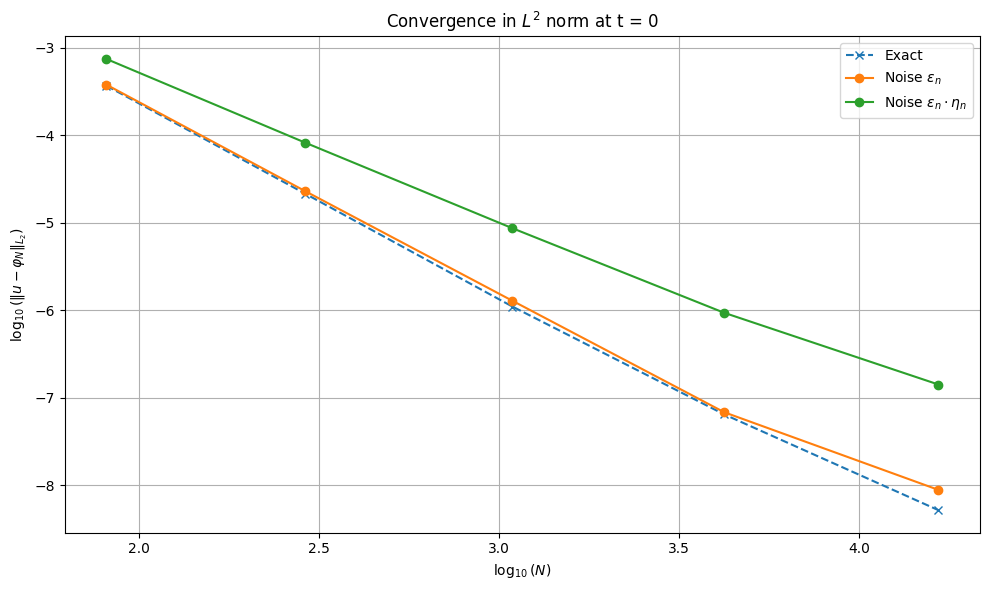

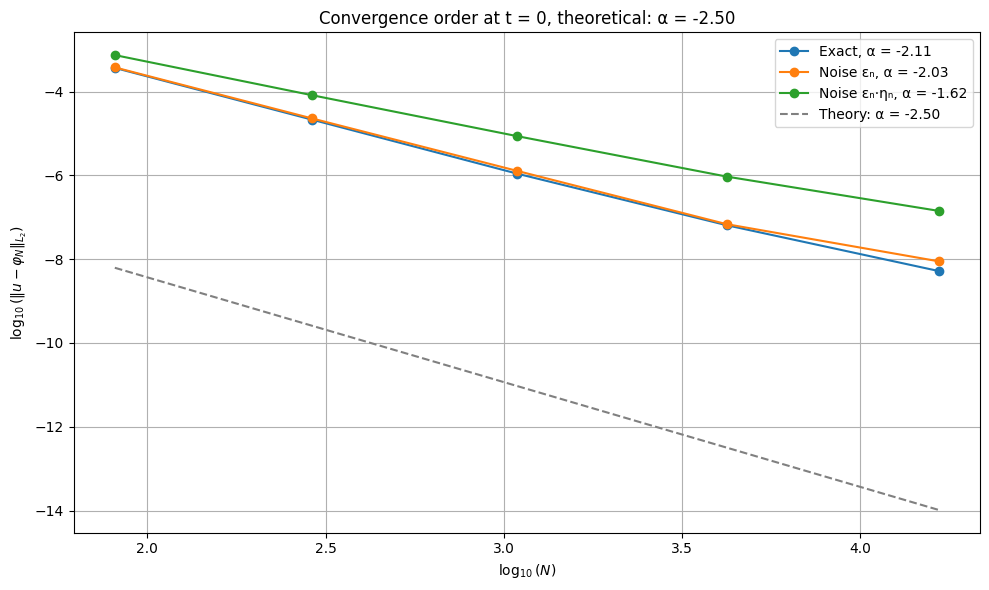

In [17]:
df, α1, α2, α3  = run_convergence_analysis(t_val=0, mode = "random", eta_function = lambda n: n + 1)

In [ ]:
 df[['n','N','eps_n', 'L2_exact', 'L2_eps','L2_eta']]

,n,N,eps_n,L2_exact,L2_eps,L2_eta
0,2,81,1.693509e-05,3.687152e-04,3.809466e-04,7.454936e-04
1,3,289,7.042963e-07,2.154965e-05,2.309643e-05,8.253381e-05
2,4,1089,2.555232e-08,1.105406e-06,1.275540e-06,8.680455e-06
3,5,4225,8.618530e-10,6.473712e-08,6.883524e-08,9.378825e-07
4,6,16641,2.799313e-11,5.213664e-09,8.970818e-09,1.421841e-07
